In [173]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

In [135]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jack\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jack\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jack\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [137]:
# Load the dataset
df = pd.read_csv('tweets.csv', encoding='latin1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [139]:
# Preprocess the dataset
df.rename(columns={'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'brand_product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)
dict_sent = {'No emotion toward brand or product': "No emotion", 'Positive emotion': 'Positive', 'Negative emotion': 'Negative', "I can't tell": 'Invalid'}
df['sentiment'] = df['sentiment'].map(dict_sent)
df['tweet'].dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.drop(index=df[df['tweet'].isna()].index, inplace=True)
df.head()

,tweet,brand_product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


In [141]:
# Fill missing 'brand_product' values
categories = np.array(['iPad', 'Apple', 'iPad', 'iPhone', 'Google', 'Android'])
def fill_missing_brand_product(df, categories):
    for i, row in df.iterrows():
        if pd.isnull(row['brand_product']):
            for category in np.concatenate((categories, np.char.lower(categories))):
                if category in row['tweet']:
                    df.loc[i, 'brand_product'] = category
                    break

fill_missing_brand_product(df, categories)

df.head()

,tweet,brand_product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


In [143]:
# Define preprocess_text function
def preprocess_text(df):
    df['cleaned_tweet'] = df['tweet'].apply(lambda x: re.sub(f'[{string.punctuation}]', '', x.lower()))
    # df['user_name'] = df['cleaned_tweet'].apply(lambda x: x.split()[0] if x else '')
    # df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: ' '.join(x.split()[1:]) if x else '')
    return df
preprocess_text(df)

,tweet,brand_product,sentiment,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,wesley83 i have a 3g iphone after 3 hrs tweeti...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,jessedee know about fludapp awesome ipadiphon...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,swonderlin can not wait for ipad 2 also they s...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,sxsw i hope this years festival isnt as crashy...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,sxtxstate great stuff on fri sxsw marissa maye...
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive,ipad everywhere sxsw link
9089,"Wave, buzz... RT @mention We interrupt your re...",google,No emotion,wave buzz rt mention we interrupt your regular...
9090,"Google's Zeiger, a physician never reported po...",Google,No emotion,googles zeiger a physician never reported pote...
9091,Some Verizon iPhone customers complained their...,iPhone,No emotion,some verizon iphone customers complained their...


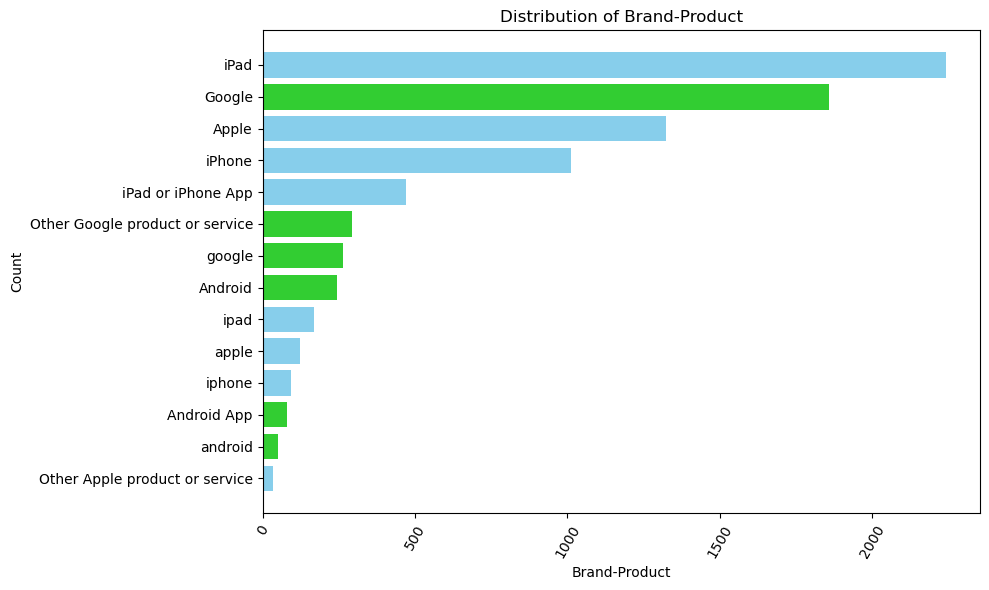

In [145]:

#sorting the Series based on its values in ascending order.
brand_counts = df['brand_product'].value_counts()
brand_counts = brand_counts.sort_values(ascending = True)

# Brand Value_counts bar plot
plt.figure(figsize=(10, 6))
colors = [
    'skyblue' #highlight any apple product in blue 
    if brand.lower() in [
        'ipad', 
        'apple', 
        'ipad or iphone app', 
        'iphone', 
        'other apple product or service'
    ] 
    else 'limegreen' for brand in brand_counts.index #highlight any google product in limegreen
]

plt.barh(brand_counts.index, brand_counts.values, color=colors)
plt.xlabel('Brand-Product')
plt.ylabel('Count')
plt.title('Distribution of Brand-Product')
plt.xticks(rotation=60) 

plt.tight_layout()
plt.show()

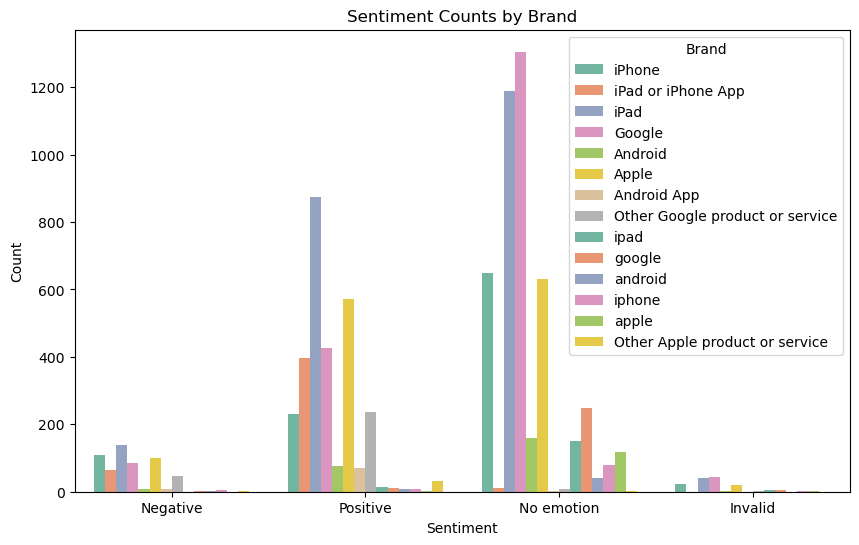

In [147]:
senti_counts = df['sentiment'].value_counts()

# Grouping by brand and aggregating the counts
brand_counts = df.groupby('brand_product')['sentiment'].value_counts().unstack(fill_value=0)

# Plotting the count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', hue='brand_product', palette='Set2')
plt.title('Sentiment Counts by Brand')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Brand')
plt.show()


In [149]:
# Vectorize text data
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X = vectorizer.fit_transform(df['cleaned_tweet'])
y = df['sentiment']

In [151]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

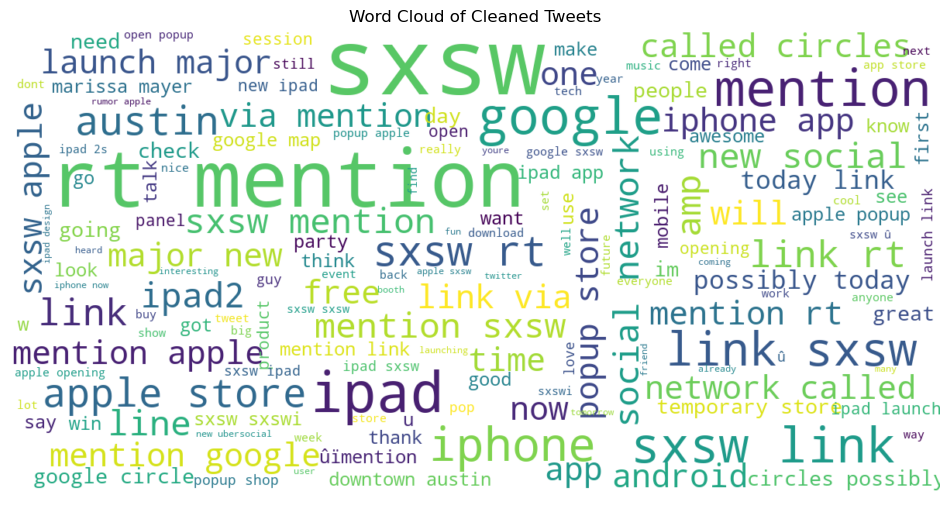

In [157]:
# Wordcloud after vectorization visualization
all_tweets_text = ' '.join(df['cleaned_tweet'])

# Create a WordCloud object
wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=40, scale=3, random_state=42)
wordcloud.generate(all_tweets_text)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Tweets')
plt.show()

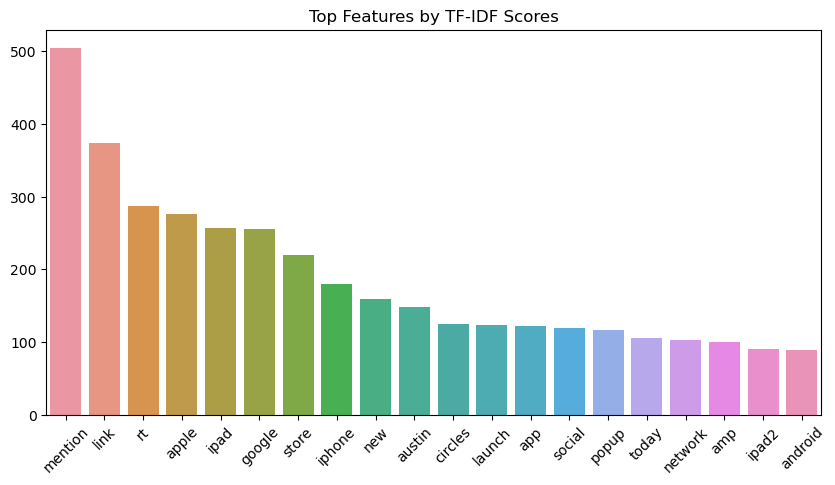

In [169]:
# Get the top features by TF-IDF scores
feature_array = vectorizer.get_feature_names_out()
tfidf_sorting = X_train.sum(axis=0).A1.argsort()[::-1]

top_n = 20
top_features = feature_array[tfidf_sorting][:top_n]

plt.figure(figsize=(10, 5))
sns.barplot(x=top_features, y=X_train.sum(axis=0).A1[tfidf_sorting][:top_n])
plt.xticks(rotation=45)
plt.title('Top Features by TF-IDF Scores')
plt.show()


In [177]:
# Train and evaluate multiple Classification models
models = {
    'Naive Bayes': MultinomialNB(),
    'SVC': LinearSVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100)
}

In [179]:
results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

C:\Users\jack\Documents\Flatiron\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jack\Documents\Flatiron\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jack\Documents\Flatiron\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jack\Documents\Flatiro

In [180]:
# Print evaluation results
for model_name, result in results.items():
    print(f"{model_name} Evaluation:")
    print(f"Accuracy: {result['accuracy']}")
    print(f"Confusion Matrix:\n{result['confusion_matrix']}")
    print(f"Classification Report:\n{result['classification_report']}")
    print("\n")

Naive Bayes Evaluation:
Accuracy: 0.6620727673649394
Confusion Matrix:
[[   0    0   28    5]
 [   0    2   88   29]
 [   0    0 1033   73]
 [   0    0  390  166]]
Classification Report:
              precision    recall  f1-score   support

     Invalid       0.00      0.00      0.00        33
    Negative       1.00      0.02      0.03       119
  No emotion       0.67      0.93      0.78      1106
    Positive       0.61      0.30      0.40       556

    accuracy                           0.66      1814
   macro avg       0.57      0.31      0.30      1814
weighted avg       0.66      0.66      0.60      1814



SVC Evaluation:
Accuracy: 0.6957001102535832
Confusion Matrix:
[[  2   1  19  11]
 [  1  34  51  33]
 [  3  16 910 177]
 [  1   4 235 316]]
Classification Report:
              precision    recall  f1-score   support

     Invalid       0.29      0.06      0.10        33
    Negative       0.62      0.29      0.39       119
  No emotion       0.75      0.82      0.78      1

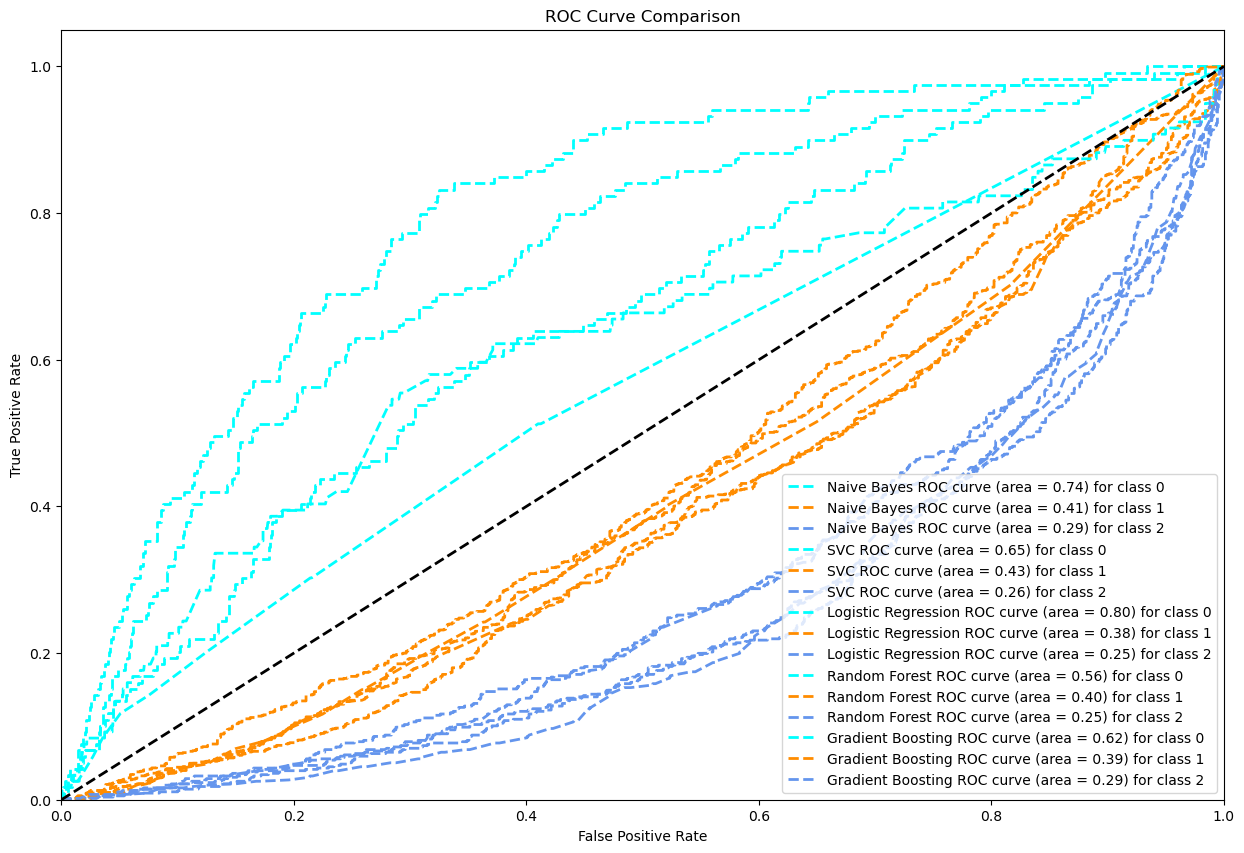

In [191]:
# Plot ROC Curves
plt.figure(figsize=(15, 10))

for model_name, result in results.items():
    model = result['model']
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
    else:
        y_proba = model.decision_function(X_test)
        
    # Handle binary or multiclass probabilities
    if y_proba.ndim == 1:
        y_proba = np.column_stack([1 - y_proba, y_proba])
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i] if hasattr(model, 'predict_proba') else y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, linestyle='--',
                 label=f'{model_name} ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()


In [193]:
# Load new data for test
new_data = pd.read_csv('sample_new_tweets.csv')  # Ensure this path matches where you saved the file

# Preprocess the new data
new_data = preprocess_text(new_data)
new_data['cleaned_tweet'] = new_data['cleaned_tweet']

# Vectorize the new data using the same vectorizer
new_data_tfidf = vectorizer.transform(new_data['cleaned_tweet'])

# Predict sentiments using the selected model
selected_model = results['Naive Bayes']['model'] 
new_data['predicted_sentiment'] = selected_model.predict(new_data_tfidf)

# Display the predictions
print(new_data[['tweet', 'predicted_sentiment']])

                                               tweet predicted_sentiment
0          I love my new iPhone! It works perfectly.          No emotion
1              My Google Pixel phone keeps crashing.            Positive
2        The battery life on my new iPad is amazing.            Positive
3          The Android OS is too complicated for me.          No emotion
4              Apple customer service is so helpful!          No emotion
5  I am disappointed with the performance of my G...          No emotion
6            This new iPhone update is really buggy.          No emotion
7    The design of the new iPad is sleek and modern.          No emotion


In [197]:
# Load new data for test
new_data = pd.read_csv('sample_new_tweets.csv')  # Ensure this path matches where you saved the file

# Preprocess the new data
new_data = preprocess_text(new_data)
new_data['cleaned_tweet'] = new_data['cleaned_tweet']

# Vectorize the new data using the same vectorizer
new_data_tfidf = vectorizer.transform(new_data['cleaned_tweet'])

# Predict sentiments using the selected model
selected_model = results['SVC']['model'] 
new_data['predicted_sentiment'] = selected_model.predict(new_data_tfidf)

# Display the predictions
print(new_data[['tweet', 'predicted_sentiment']])

                                               tweet predicted_sentiment
0          I love my new iPhone! It works perfectly.            Positive
1              My Google Pixel phone keeps crashing.            Positive
2        The battery life on my new iPad is amazing.            Positive
3          The Android OS is too complicated for me.          No emotion
4              Apple customer service is so helpful!            Positive
5  I am disappointed with the performance of my G...            Positive
6            This new iPhone update is really buggy.            Negative
7    The design of the new iPad is sleek and modern.            Positive


In [199]:
# Load new data for test
new_data = pd.read_csv('sample_new_tweets.csv')  # Ensure this path matches where you saved the file

# Preprocess the new data
new_data = preprocess_text(new_data)
new_data['cleaned_tweet'] = new_data['cleaned_tweet']

# Vectorize the new data using the same vectorizer
new_data_tfidf = vectorizer.transform(new_data['cleaned_tweet'])

# Predict sentiments using the selected model
selected_model = results['Logistic Regression']['model'] 
new_data['predicted_sentiment'] = selected_model.predict(new_data_tfidf)

# Display the predictions
print(new_data[['tweet', 'predicted_sentiment']])

                                               tweet predicted_sentiment
0          I love my new iPhone! It works perfectly.            Positive
1              My Google Pixel phone keeps crashing.            Positive
2        The battery life on my new iPad is amazing.            Positive
3          The Android OS is too complicated for me.          No emotion
4              Apple customer service is so helpful!            Positive
5  I am disappointed with the performance of my G...          No emotion
6            This new iPhone update is really buggy.            Positive
7    The design of the new iPad is sleek and modern.            Positive


In [201]:
# Load new data for test
new_data = pd.read_csv('sample_new_tweets.csv')  # Ensure this path matches where you saved the file

# Preprocess the new data
new_data = preprocess_text(new_data)
new_data['cleaned_tweet'] = new_data['cleaned_tweet']

# Vectorize the new data using the same vectorizer
new_data_tfidf = vectorizer.transform(new_data['cleaned_tweet'])

# Predict sentiments using the selected model
selected_model = results['Random Forest']['model'] 
new_data['predicted_sentiment'] = selected_model.predict(new_data_tfidf)

# Display the predictions
print(new_data[['tweet', 'predicted_sentiment']])

                                               tweet predicted_sentiment
0          I love my new iPhone! It works perfectly.            Positive
1              My Google Pixel phone keeps crashing.          No emotion
2        The battery life on my new iPad is amazing.            Positive
3          The Android OS is too complicated for me.          No emotion
4              Apple customer service is so helpful!          No emotion
5  I am disappointed with the performance of my G...          No emotion
6            This new iPhone update is really buggy.          No emotion
7    The design of the new iPad is sleek and modern.            Positive


In [203]:
# Load new data for test
new_data = pd.read_csv('sample_new_tweets.csv')  # Ensure this path matches where you saved the file

# Preprocess the new data
new_data = preprocess_text(new_data)
new_data['cleaned_tweet'] = new_data['cleaned_tweet']

# Vectorize the new data using the same vectorizer
new_data_tfidf = vectorizer.transform(new_data['cleaned_tweet'])

# Predict sentiments using the selected model
selected_model = results['Gradient Boosting']['model'] 
new_data['predicted_sentiment'] = selected_model.predict(new_data_tfidf)

# Display the predictions
print(new_data[['tweet', 'predicted_sentiment']])

                                               tweet predicted_sentiment
0          I love my new iPhone! It works perfectly.            Positive
1              My Google Pixel phone keeps crashing.          No emotion
2        The battery life on my new iPad is amazing.            Positive
3          The Android OS is too complicated for me.          No emotion
4              Apple customer service is so helpful!          No emotion
5  I am disappointed with the performance of my G...          No emotion
6            This new iPhone update is really buggy.          No emotion
7    The design of the new iPad is sleek and modern.            Positive
